In [ ]:
from app import data_imports
from app import data_cleaning
from app import summary_stats   
from app import models
from app import visualisations

# Where is the dataset?

In [174]:
filepath = 'examples/happiness_2019.csv'

In [175]:
# SYSTEM CODE

import os

if os.path.isfile(filepath):
    print('\033[92;1m' + 'File successfully found!' + '\033[0m')
else:
    raise SystemExit("File not found. Stopping execution.")


SystemExit: File not found. Stopping execution.

To exit: use 'exit', 'quit', or Ctrl-D.


In [ ]:
# SYSTEM CODE

df = data_imports.read_file(filepath)

cleaner = data_cleaning.DataCleaner(df)

cleaner.clean()

print(cleaner.get_log())

In [ ]:
# SYSTEM CODE

cols = df.columns.tolist()

cols_str = '\n'.join([f"- {col} ({df[col].dtype})" for col in cols])
print("The columns in the dataset are:\n")
print(cols_str)

# Do you have interest in any specific variable?

It is not practical to consider all relationships at the same time. 

**You do not have to specify any variables at all.** The explanatory statistics will then be applied to all variables at once. Note that the modelling will, however, be limited.

In [ ]:
# e.g. target_variable = 'price'
target_variable = ''

# e.g. other_variables_of_interest = ['sqft_living', 'bedrooms', 'bathrooms']
other_variables_of_interest = []#'b', 'lstat', 'rm']

In [ ]:
# SYSTEM CODE

if not target_variable and not other_variables_of_interest:
    print('\033[91;1m' + "Both target_variable and other_variables_of_interest are empty." + '\033[0m')
elif not target_variable and other_variables_of_interest:
    print('\033[91;1m' + "Target variable has not been specified. Proceeding with the first column in the dataset." + '\033[0m')
    target_variable = df.columns[0] 
elif target_variable and not other_variables_of_interest:
    other_variables_of_interest = df.columns.tolist()
    print('\033[91;1m' + "Other variables of interest have not been specified. Proceeding with the whole dataset." + '\033[0m')

if target_variable in other_variables_of_interest:
    other_variables_of_interest.remove(target_variable)


In [ ]:
# SYSTEM CODE

if target_variable and other_variables_of_interest:
    summary_stats.numeric_statistics(df[[target_variable] + other_variables_of_interest])
    summary_stats.categorical_statistics(df[[target_variable] + other_variables_of_interest])
elif target_variable:
    print(summary_stats.numeric_statistics(df[[target_variable]]))
    print(summary_stats.categorical_statistics(df[[target_variable]]))
else:
    print(summary_stats.numeric_statistics(df))
    print(summary_stats.categorical_statistics(df))


In [ ]:
# SYSTEM CODE

visualiser = visualisations.Visualization(df, variables=other_variables_of_interest, target=target_variable)

visualiser.plot_all()

In [ ]:
from app import relationship_detection

relationship_summary = relationship_detection.analyze_relationships(df)
for pair, (type_pair, value) in relationship_summary.items():
    print(f"Relationship between {pair[0]} and {pair[1]} ({type_pair}): {value}")

In [218]:
from scipy.stats import uniform

model_type='lasso'#random_forest', lasso, ridge,linear_regression
search_method='random_search'#grid_search, random_search,bayesian_optimization, none (for e.g. linear regression)
# e.g. target_variable = 'price'
target = 'Score'

# e.g. other_variables_of_interest = ['sqft_living', 'bedrooms', 'bathrooms']
modeling_variables= ['GDP per capita','Social support','Healthy life expectancy']#'b', 'lstat', 'rm']
hyperpar_grid = {
    'alpha': uniform(0.001, 1.0),  # Range for regularization strength
    'fit_intercept': [True, False],  # Whether to calculate the intercept for the model
    'max_iter': [100, 200, 300, 400, 500],  # Maximum number of iterations for optimization
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],  # Tolerance for optimization convergence
}
# random_forest example: {'n_estimators': [10,20,30,150], 'max_depth': [None, 10, 20,30]}
#lasso example: {'alpha': uniform(0.001, 1.0),  # Range for regularization strength,'fit_intercept': [True, False],'max_iter': [100, 200, 300, 400, 500], 'tol': [1e-4, 1e-3, 1e-2, 1e-1]}
cv = 10
n_iter=15
random_state = 42


In [ ]:
# SYSTEM CODE

model = models.RegressionModel(model_type=model_type, hyperpar_grid=hyperpar_grid,cv = cv, n_iter=n_iter, random_state=random_state)
model.split_data(df, variables=modeling_variables, target=target, test_size=0.2)
model.train(search_method=search_method)

mse = model.evaluate()
print(f"Mean Squared Error: {mse}")



In [ ]:
# for custom predictions
model.predict(model.X_test) # replace with your own values, TODO: figure out imports and implement visualisations

In [222]:
index = [0,1] # replace with your own values
import importlib
from app import visualisations
importlib.reload(visualisations)

<module 'app.visualisations' from '/Users/tony/Documents/škola/IES/Python/JEM207FinalProject/app/visualisations.py'>

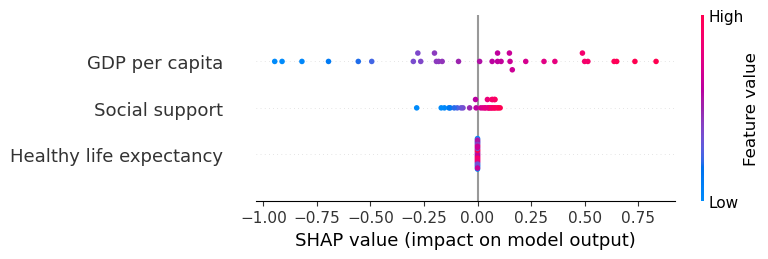

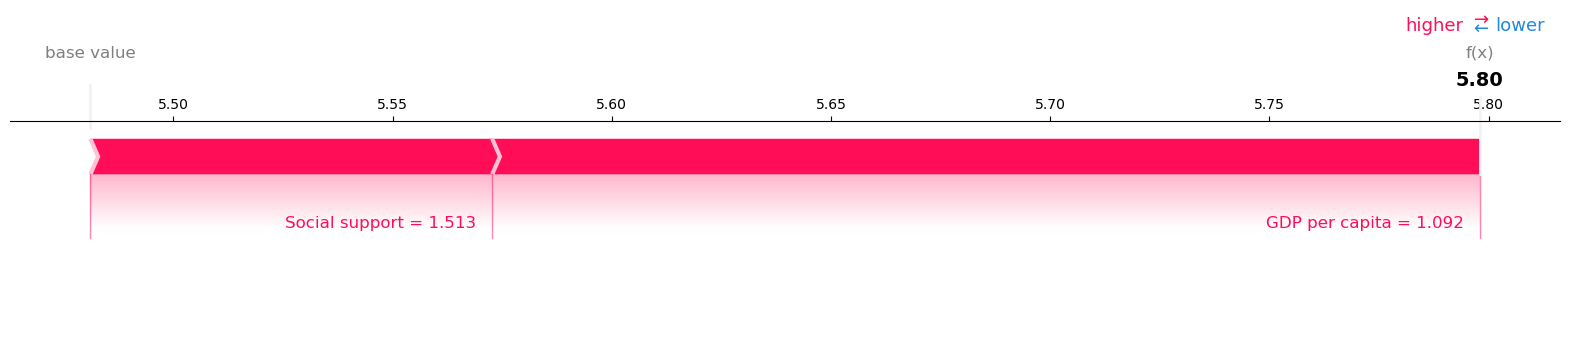

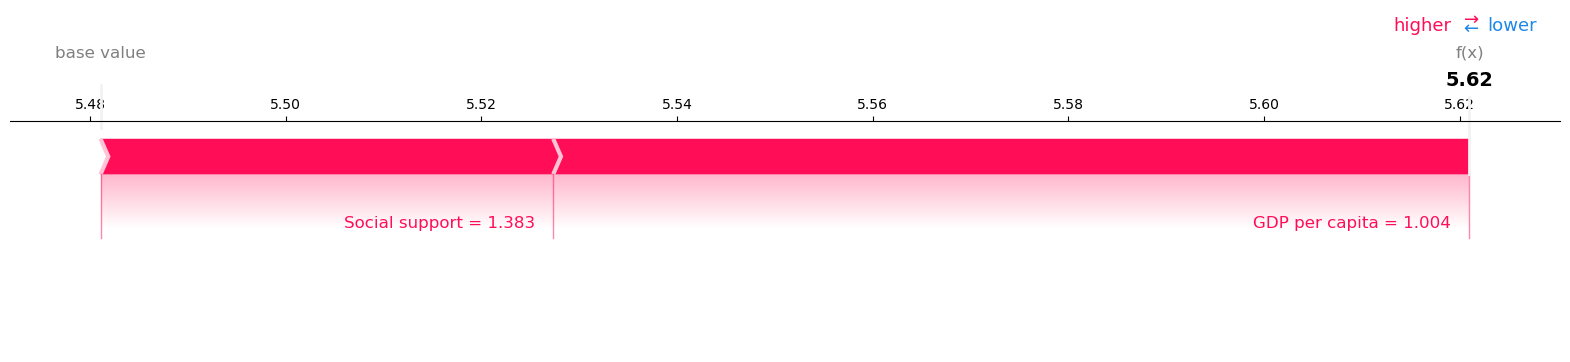

In [223]:
# SYSTEM CODE
from app import visualisations
visualization = visualisations.Visualization(df,model=model, X_test=model.X_test,model_type=model_type)
visualization.generate_shap_values()
visualization.plot_shap_summary()
for i in range(len(index)):
    visualization.plot_shap_force(index=index[i])
